Under the condition where epoch = 100, compare three kinds of convnets using different training ways:

1. Firstly train digits 0~4, then 5~9
2. Firstly train digits 0~4, then 0~9
3. Firstly train digits 0~9

Compare way:

1. curves' shape
2. accuracy on test sets
3. **[Note]** Conclusions must be based on means of results from multiple experients, 5 at least.

You should commit:

1. Source code
2. A PDF report with details of experiments, including details of methods, results in graphs and conclusion.

 --------------------------------------------------------------

# -1. Preparation

In [1]:
#import modules
import os
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable

from IPython.display import display
%matplotlib inline

In [2]:
# define some constant variables

use_cuda = torch.cuda.is_available()
dtype_float = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
dtype_long = torch.cuda.LongTensor if use_cuda else torch.LongTensor

In [3]:
import torchvision

# prepare MNIST

path_datasets = './datasets'

transform_set = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
data_train = torchvision.datasets.MNIST(root=path_datasets, train=True, download=True, 
                                        transform=transform_set) 
data_test = torchvision.datasets.MNIST(root=path_datasets, train=False, download=True,
                                        transform=transform_set)

In [4]:
batch_size = 100
n_class = 10

##dataloader_train
dataloader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)

##dataloader_valid

indices_valid = range(len(data_test)//2)
sampler_valid = torch.utils.data.sampler.SubsetRandomSampler(indices=indices_valid)
dataloader_valid = torch.utils.data.DataLoader(dataset=data_test, batch_size=batch_size, sampler=sampler_valid)

##dataloader_test

indices_test = range(len(data_test)//2, len(data_test))
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices=indices_test)

dataloader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size=batch_size, sampler=sampler_test)

## 查看三个数据迭代器的结果

,0
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851
9,5949


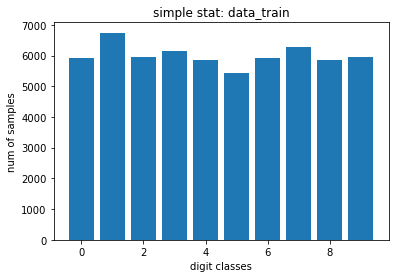

In [5]:
count = {i:0 for i in range(n_class)}
for i,data in enumerate(dataloader_train):
    xs,ys = data
    for y in ys:
        count[y] += 1

count = [count[i] for i in range(n_class)]
display(pd.DataFrame(data=count))
plt.bar(left=np.arange(n_class), height=count)
plt.xlabel('digit classes')
plt.ylabel('num of samples')
plt.title('simple stat: data_train')
plt.show()

,0
0,460
1,571
2,530
3,500
4,500
5,456
6,462
7,512
8,489
9,520


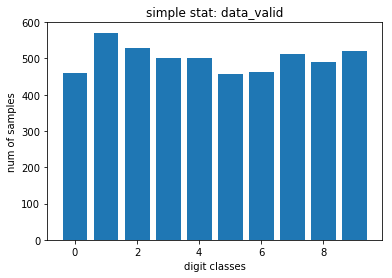

In [6]:
count = {i:0 for i in range(n_class)}
for i,data in enumerate(dataloader_valid):
    xs,ys = data
    for y in ys:
        count[y] += 1

count = [count[i] for i in range(n_class)]
display(pd.DataFrame(data=count))
plt.bar(left=np.arange(n_class), height=count)
plt.xlabel('digit classes')
plt.ylabel('num of samples')
plt.title('simple stat: data_valid')
plt.show()

,0
0,520
1,564
2,502
3,510
4,482
5,436
6,496
7,516
8,485
9,489


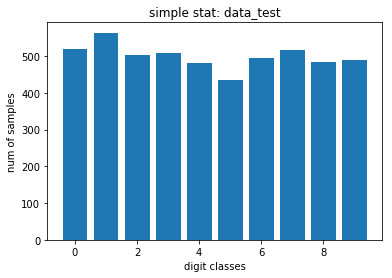

In [7]:
count = {i:0 for i in range(n_class)}
for i,data in enumerate(dataloader_test):
    xs,ys = data
    for y in ys:
        count[y] += 1

count = [count[i] for i in range(n_class)]
display(pd.DataFrame(data=count))
plt.bar(left=np.arange(n_class), height=count)
plt.xlabel('digit classes')
plt.ylabel('num of samples')
plt.title('simple stat: data_test')
plt.show()

# 0. ConvNet class

In [8]:
from  torch.nn import functional as F

n_channels = 1
n_class = 10
size_image = 28

depth = [8, 16, 32]
fc = [1024, 128, n_class]
ksize = [5, 5, 5]
pad = [2, 2, 2]

net_names = []

# define class

class ConvNet(nn.Module):
    
    def __init__(self, init_name):
        super(ConvNet, self).__init__()
        # init
        global net_names
        assert init_name not in net_names, "Name existed: {}".format(net_names)
        net_names.append(init_name)
        self.name = init_name
        
        # conv-net
        self.conv00 = nn.Conv2d(in_channels=n_channels, out_channels=depth[0], kernel_size=ksize[0], padding=pad[0])
        self.conv01 = nn.Conv2d(in_channels=depth[0], out_channels=depth[1], kernel_size=ksize[1], padding=pad[1])
        self.conv02 = nn.Conv2d(in_channels=depth[1], out_channels=depth[2], kernel_size=ksize[2], padding=pad[2])
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # full-connect
        self.fc00 = nn.Linear(in_features=(size_image//4//2)*(size_image//4//2)*depth[2], out_features=fc[0])
        self.fc01 = nn.Linear(in_features=fc[0], out_features=fc[1])
        self.fc02 = nn.Linear(in_features=fc[1], out_features=fc[2])
        
        self.bn1d = nn.BatchNorm1d(num_features=fc[1])
        
    def rename(self, new_name):
        global net_names
        net_names.remove(self.name)
        self.name = new_name
        net_names.append(new_name)
    
    def forward(self, x, training=True):
        x = F.leaky_relu(self.conv00(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv01(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv02(x))
        x = self.maxpool(x)
        x = x.view(-1, (size_image//4//2)*(size_image//4//2)*depth[2])
        
        x = F.leaky_relu(self.fc00(x))
        x = F.dropout(x, training=self.training)
        x = F.leaky_relu(self.fc01(x))
        x = self.bn1d(x)
        x = F.leaky_relu(self.fc02(x))
        
        return x

In [9]:
def evaludate_acc(y, target):
    if isinstance(target, torch.autograd.Variable):
        target = target.cpu().data if use_cuda else target.data
    if isinstance(y, torch.autograd.Variable):
        y = y.cpu().data if use_cuda else y.data
    pred = torch.max(y, dim=1)[-1]
    rights = pred.eq(target).sum()
    length = y.size()[0]
    acc = 1.0 * rights / length
    return (acc, rights, length)

In [10]:
# define training function using specified digits


def train_net(net, loss_func, optimizer, digit_range, sum_epochs=15, interval_valid=50):
    bag_loss = {'train':[], 'valid':[]}
    bag_acc = {'train':[], 'valid':[]}
    for epoch in range(sum_epochs):
        for idx,batch in enumerate(dataloader_train):
            # set net state
            net.train()

            # fetch batch for this round, then choose points that are in `digit_range`
            xs_raw, ys_raw = batch
            xs, ys = [], []
            for (data,label) in zip(xs_raw, ys_raw):
                if label in digit_range:
                    xs.append(data.unsqueeze(0))
                    ys.append(label)
            xs = torch.cat(xs)
            ys = torch.from_numpy(np.array(ys))
            xs, ys = (xs.cuda(), ys.cuda()) if use_cuda else (xs, ys)
            
            # pack in Variable
            xs, ys = Variable(xs), Variable(ys)  # easy to forget packing `ys` in `Variable`

            # predictions
            preds = net(xs)

            # count loss
            loss_train = loss_func(preds, ys)

            # clear grad and backwoard
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            if idx % interval_valid == 0:
                # set net state
                net.eval()

                # TODO: validation
                acc_valid, loss_valid = [], []
                for jdx, batch_v in enumerate(dataloader_valid):
                    xs_v, ys_v = batch_v
                    xs_v, ys_v = (xs_v.cuda(), ys_v.cuda()) if use_cuda else (xs_v, ys_v)
                    xs_v, ys_v = Variable(xs_v), Variable(ys_v)
                    preds_v = net(xs_v)
                    loss_valid_raw = loss_func(preds_v, ys_v)
                    loss_valid.append(loss_valid_raw.cpu().data.numpy() if use_cuda else \
                                      loss_valid_raw.data.numpy())
                    acc_valid.append(evaludate_acc(preds_v, ys_v)[0])

                train_xs_raw, train_ys_raw = (xs_raw.cuda(), ys_raw.cuda()) if use_cuda else (xs_raw, ys_raw)
                acc_train = evaludate_acc(net(Variable(train_xs_raw)), Variable(train_ys_raw))[0]
                acc_valid = np.mean(acc_valid)
                loss_valid = np.mean(loss_valid)
                bag_loss['train'].append(loss_train.cpu().data.numpy() if use_cuda else loss_train.data.numpy())
                bag_loss['valid'].append(loss_valid)
                bag_acc['train'].append(acc_train)
                bag_acc['valid'].append(acc_valid)

                print('[Epoch: {}/{}] [Batch: {}/{}] [Loss-mean(train): {:.4f}] [Loss-mean(validation): {:.4f}] \
[Acc-mean(train): {:.4f}] [Acc-mean(validation): {:.4f}]'.format(
                    epoch, sum_epochs, idx, len(dataloader_train),
                    np.mean(bag_loss['train']), 
                    np.mean(bag_loss['valid']), 
                    np.mean(bag_acc['train']), 
                    np.mean(bag_acc['valid'])
                ), end='\r') #print in-place
                
    return (bag_loss, bag_acc, net)

In [18]:
# import module needed
import copy
import datetime
import matplotlib.markers as plt_markers


# define helper class
class CoachTeam_new(object):
    
    def __init__(self, net, optimizer, loss_func, 
                 stage_names=['train', 'valid', 'test'], ind_names=['loss', 'acc']):
        # net components
        self.net = copy.deepcopy(net)
        assert hasattr(self.net, 'name'), 'The nn object you want to use should have \
an attribute called `name`.'
        self.optimizer = optimizer(self.net.parameters())
        self.loss_func = loss_func
        
        # helper generator
        empty_markers = ['None', None, ' ', '']
        self.plt_markers = (mk for mk in plt_markers.MarkerStyle.markers.keys() if mk not in empty_markers)

        # storage
        self.stage_names = stage_names
        self.ind_names = ind_names
        self.results = {ind:{stage:[] for stage in self.stage_names} for ind in self.ind_names}
        
    def pipeline_helper(self, n_iters, digit_rangesss, sum_epochs=15, interval_valid=100, dirname_prefix='outputs'):
        # set dirname
        self.dirname = dirname_prefix + '_' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
        if not os.path.isdir(self.dirname):
            os.mkdir(self.dirname)
        for i in range(n_iters):
            # reset data for each experiment
            net = copy.deepcopy(self.net)
            self.results = {ind:{stage:[] for stage in self.stage_names} for ind in self.ind_names}
            
            # working pipeline
            self.train_helper(net, self.loss_func, self.optimizer, digit_rangesss, 
                              sum_epochs=sum_epochs, interval_valid=interval_valid)
            self.test_helper(self.net)
            self.save(mode='file', netname=net.name, suffix=str(i))
            num_valid = sum_epochs * len(dataloader_train) // interval_valid
            self.plot_single(net.name, plot_test=False, suffix=str(i), num_valid=num_valid)
            self.plot_single(net.name, plot_test=True, suffix=str(i))
            print('Round {}: OK'.format(i))
            print('---------------------------------')
        print('==================================================')
        self.plot_whole(net.name, n_iters=n_iters, plot_test=False, plot_origin=True, plot_mean=True, num_valid=num_valid)
        self.plot_whole(net.name, n_iters=n_iters, plot_test=False, plot_origin=True, plot_mean=False, num_valid=num_valid)
        self.plot_whole(net.name, n_iters=n_iters, plot_test=False, plot_origin=False, plot_mean=True, num_valid=num_valid)
        self.plot_whole(net.name, n_iters=n_iters, plot_test=True, plot_origin=True, plot_mean=True)
        self.plot_whole(net.name, n_iters=n_iters, plot_test=True, plot_origin=True, plot_mean=False)
        self.plot_whole(net.name, n_iters=n_iters, plot_test=True, plot_origin=False, plot_mean=True)
        print('Finish all the pipeline.')    
        
        
    def train_helper(self, net, loss_func, optimizer, digit_rangesss, sum_epochs=15, interval_valid=50):
        # train and validate, using digit_range sequences
        for idx,digit_range in enumerate(digit_rangesss):
            raw_out = {ind:[] for ind in self.ind_names}

            raw_out['loss'], raw_out['acc'], net = train_net(
                net=net, loss_func=loss_func, optimizer=optimizer, digit_range=digit_range,
                sum_epochs=sum_epochs//len(digit_rangesss), interval_valid=interval_valid
            )
            
            # save in RAM: train_data and valid_data 
            self.save(mode='dict-results', data=raw_out)
            print()
            print('Save data(train & validation): OK in RAM, for', digit_range)
        print('Train net: OK')
        
    def test_helper(self, net):
        # test(evaluate)
        net.eval()
        
        raw_out = {ind:{'test':[]} for ind in self.ind_names}
        for kdx, batch_t in enumerate(dataloader_test):
            xs_t, ys_t = batch_t
            xs_t, ys_t = (xs_t.cuda(), ys_t.cuda()) if use_cuda else (xs_t, ys_t)
            xs_t, ys_t = Variable(xs_t), Variable(ys_t)
            preds_t = net(xs_t)
            loss_test_raw = loss_func(preds_t, ys_t)
            raw_out['loss']['test'].append(loss_test_raw.cpu().data.numpy() if use_cuda \
                                           else loss_test_raw.data.numpy())
            raw_out['acc']['test'].append(evaludate_acc(preds_t, ys_t)[0])
        
        # save in RAM: test_data
        self.save(mode='dict-results', data=raw_out, stages=['test'])
        print('Save data(test): OK in RAM')
        
    def save(self, mode, data=None, netname=None, stages=['train', 'valid'], suffix=None):        
        if 'dict-results' == mode:
            assert data is not None, 'Your should specify the data you want to save in RAM.'
            for ind in self.ind_names:
                for stage in stages:
                    items = [i[0] if isinstance(i, np.ndarray) else i for i in data[ind][stage]]
                    if stage not in self.results[ind]:
                        self.results[ind][stage] = copy.deepcopy(items)
                    else:
                        self.results[ind][stage].extend(items)
        
        if 'file' == mode:
            assert netname is not None, 'You should specify the **NAME** of this neural network.'
            
            lacks = []
            for stage in self.stage_names:
                tmp_pd = {ind:copy.deepcopy(self.results[ind][stage]) for ind in self.ind_names}
                tmp_pd = pd.DataFrame(data=tmp_pd, columns=self.ind_names)
                if suffix:
                    filename = os.path.join(os.getcwd(), self.dirname, 
                                            '{}-sheet-{}-{}.csv'.format(netname, stage, suffix))
                else:
                    filename = os.path.join(os.getcwd(), self.dirname, 
                                            '{}-sheet-{}.csv'.format(netname, stage))
                    
                # write to csv
                if os.path.isfile(filename):
                    pd_source = pd.read_csv(filename)
                    tmp_pd = pd.concat([pd_source, tmp_pd])
                    tmp_pd.to_csv(filename, index=False) 
                else:
                    tmp_pd.to_csv(filename, index=False)
                        
                print('Save data in file OK:', filename)
    
    def plot_single(self, netname, suffix=None, plot_test=True, num_valid=None):        
        if plot_test:
            # plot: test
            
            x_inds = np.arange(len(dataloader_test))
            fig, axes_raw = plt.subplots(1, len(self.ind_names), figsize=(15,5))
            axes = {ind:axes_raw[i] for i,ind in enumerate(self.ind_names)}
            for ind in self.ind_names:
                axes[ind].plot(x_inds, self.results[ind]['test'], label='{}_test'.format(ind))
                axes[ind].set_xlabel('num_iter')
                axes[ind].set_ylabel(ind)
            
            if suffix:
                filename = os.path.join(os.getcwd(), self.dirname, 
                                        '{}-curves_test-{}'.format(netname, suffix))
            else:
                filename = os.path.join(os.getcwd(), self.dirname, '{}-curves_test'.format(netname))
                
            plt.savefig(filename)
            
        if not plot_test:
            # plot: train & validation
            
            fig, axes_raw = plt.subplots(1, len(self.ind_names), figsize=(15, 5))
            axes = {self.ind_names[i]:ax for i,ax in enumerate(axes_raw) }
            
            assert num_valid is not None, 'You should specify how many times \
the validation process executed each round.'
            x_inds = np.arange(num_valid)
            for ind in ['loss', 'acc']:
                for stage in ['train', 'valid']:
                    axes[ind].plot(x_inds, self.results[ind][stage], label='{}_{}'.format(ind, stage))
                
                axes[ind].set_xlabel('num_iter')
                axes[ind].set_ylabel(ind)
                axes[ind].set_title('data on: convnet_0')
                axes[ind].legend()
            
            plt.tight_layout(w_pad=10)
            
            if suffix:
                filename = os.path.join(os.getcwd(), self.dirname, 
                                        '{}-curves-train_validation-{}'.format(netname, suffix))
            else:
                filename = os.path.join(os.getcwd(), self.dirname, '{}-curves-train_validation'.format(netname))
                
            plt.savefig(filename)

            # # fig.show() 
            # comment the command above to avoid warning 
            #`UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure`
            
    def plot_whole(self, netname, n_iters, num_valid=None, plot_test=False, plot_origin=True, plot_mean=False):
        plt_markers_gen = copy.deepcopy(self.plt_markers)
#         plt_markers_list = list([mk for mk in plt_markers.MarkerStyle.markers.keys() if mk not in empty_markers])
#         plt_markers_gen = (mk for mk in plt_markers_list)
        
        fig, axes_raw = plt.subplots(1, 2, figsize=(15, 5))
        axes = {ind:axes_raw[i] for i,ind in enumerate(self.ind_names)}
        alpha_dict = {'train':0.7 ,'valid':1.0, 'test':1.0}

        ind_data = {}
        for ind in self.ind_names:
            for stage in self.stage_names:
                k = '{}_{}-mean'.format(ind, stage)
                ind_data[k] = []
                
        if plot_test:
            x_inds = np.arange(len(dataloader_test))
            
            for i in range(n_iters):
                for stage in self.stage_names[-1:]:
                    filename = '{}-sheet-{}-{}.csv'.format(netname, stage, i)
                    filename = os.path.join(os.getcwd(), self.dirname, filename)
                    df = pd.read_csv(filename)
                    for ind in self.ind_names:
                        # save data for the mean curve
                        k = '{}_{}-mean'.format(ind, stage)
                        ind_data[k].append(df[ind].values)
                        
                        # plot
                        if plot_origin:
                            axes[ind].plot(x_inds, df[ind], label='{}_{}-{}'.format(ind, stage, i), 
                                           marker=next(plt_markers_gen), alpha=alpha_dict[stage])
            if plot_mean:
                for ind in self.ind_names:
                    for stage in self.stage_names[-1:]:
                        k = '{}_{}-mean'.format(ind, stage)
                        ind_data[k] = np.array(ind_data[k]).mean(axis=0)
                        axes[ind].plot(x_inds, ind_data[k], label=k,
                                       marker=next(plt_markers_gen), alpha=alpha_dict[stage])
        
            for ind in self.ind_names:    
                axes[ind].legend()

            plt.tight_layout(w_pad=10)

            use_origin = 'Origin' if plot_origin else 'noOrigin'
            use_mean = 'Mean' if plot_origin else 'noMean'
            filename = '{}-curves-test-whole-{}{}'.format(netname, use_origin, use_mean)
            filename = os.path.join(os.getcwd(), self.dirname, filename)
            plt.savefig(filename)
                
        if not plot_test:
            assert num_valid is not None, "You must specify the num of iterations on validation."
            # plot: train_validation
            x_inds = np.arange(num_valid)
            
            for i in range(n_iters):
                for stage in self.stage_names[:-1]:
                    filename_base = '{}-sheet-{}-{}.csv'.format(netname, stage, i)
                    filename = os.path.join(os.getcwd(), self.dirname, filename_base)
                    assert os.path.isfile(filename), 'Lack file: '.format(filename_base)
                    df = pd.read_csv(filename)
                    for ind in self.ind_names:
                        # save data for the mean curve
                        k = '{}_{}-mean'.format(ind, stage)
                        ind_data[k].append(df[ind].values)
        
                        # plot
                        if plot_origin:
                            axes[ind].plot(x_inds, df[ind], label='{}_{}-{}'.format(ind, stage, i), 
                                           marker=next(plt_markers_gen), alpha=alpha_dict[stage])

            if plot_mean:
                for ind in self.ind_names:
                    for stage in self.stage_names[:-1]:
                        k = '{}_{}-mean'.format(ind, stage)
                        ind_data[k] = np.array(ind_data[k]).mean(axis=0)
                        axes[ind].plot(x_inds, ind_data[k], label=k,
                                       marker=next(plt_markers_gen), alpha=alpha_dict[stage])

            for ind in self.ind_names:    
                axes[ind].legend()
            
            plt.tight_layout(w_pad=10)
            
            use_origin = 'Origin' if plot_origin else 'noOrigin'
            use_mean = 'Mean' if plot_origin else 'noMean'
            filename = '{}-curves-train_validation-whole-{}{}'.format(netname, use_origin, use_mean)
            filename = os.path.join(os.getcwd(), self.dirname, filename)
            plt.savefig(filename)

In [19]:
# import module needed
import copy
import datetime
import matplotlib.markers as plt_markers


# define helper class
class CoachTeam_old(object):
    
    def __init__(self, net, optimizer, loss_func, 
                 stage_names=['train', 'valid', 'test'], ind_names=['loss', 'acc']):
        # net components
        self.net = copy.deepcopy(net)
        assert hasattr(self.net, 'name'), 'The nn object you want to use should have \
an attribute called `name`.'
        self.optimizer = optimizer(self.net.parameters())
        self.loss_func = loss_func

        # storage
        self.stage_names = stage_names
        self.ind_names = ind_names
        self.results = {ind:{stage:[] for stage in self.stage_names} for ind in self.ind_names}
        
    def pipeline_helper(self, n_iters, digit_rangesss, sum_epochs=15, interval_valid=100, dirname_prefix='outputs'):
        # set dirname
        self.dirname = dirname_prefix + '_' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
        if not os.path.isdir(self.dirname):
            os.mkdir(self.dirname)
        for i in range(n_iters):
            # reset data for each experiment
            net = copy.deepcopy(self.net)
            self.results = {ind:{stage:[] for stage in self.stage_names} for ind in self.ind_names}
            
            # working pipeline
            self.train_helper(net, self.loss_func, self.optimizer, digit_rangesss, 
                              sum_epochs=sum_epochs, interval_valid=interval_valid)
            self.test_helper(self.net)
            self.save(mode='file', netname=net.name, suffix=str(i))
            num_valid = sum_epochs * len(dataloader_train) // interval_valid
            self.plot_single(net.name, plot_test=False, suffix=str(i), num_valid=num_valid)
            self.plot_single(net.name, plot_test=True, suffix=str(i))
            print('Round {}: OK'.format(i))
            print('---------------------------------')
        print('==================================================')
        self.plot_whole(net.name, n_iters=n_iters, plot_test=False, plot_origin=True, plot_mean=True, num_valid=num_valid)
        self.plot_whole(net.name, n_iters=n_iters, plot_test=False, plot_origin=True, plot_mean=False, num_valid=num_valid)
        self.plot_whole(net.name, n_iters=n_iters, plot_test=False, plot_origin=False, plot_mean=True, num_valid=num_valid)
        self.plot_whole(net.name, n_iters=n_iters, plot_test=True, plot_origin=True, plot_mean=True)
        self.plot_whole(net.name, n_iters=n_iters, plot_test=True, plot_origin=True, plot_mean=False)
        self.plot_whole(net.name, n_iters=n_iters, plot_test=True, plot_origin=False, plot_mean=True)
        print('Finish all the pipeline.')    
        
        
    def train_helper(self, net, loss_func, optimizer, digit_rangesss, sum_epochs=15, interval_valid=50):
        # train and validate, using digit_range sequences
        for idx,digit_range in enumerate(digit_rangesss):
            raw_out = {ind:[] for ind in self.ind_names}

            raw_out['loss'], raw_out['acc'], net = train_net(
                net=net, loss_func=loss_func, optimizer=optimizer, digit_range=digit_range,
                sum_epochs=sum_epochs//len(digit_rangesss), interval_valid=interval_valid
            )
            
            # save in RAM: train_data and valid_data 
            self.save(mode='dict-results', data=raw_out)
            print()
            print('Save data(train & validation): OK in RAM, for', digit_range)
        print('Train net: OK')
        
    def test_helper(self, net):
        # test(evaluate)
        net.eval()
        
        raw_out = {ind:{'test':[]} for ind in self.ind_names}
        for kdx, batch_t in enumerate(dataloader_test):
            xs_t, ys_t = batch_t
            xs_t, ys_t = (xs_t.cuda(), ys_t.cuda()) if use_cuda else (xs_t, ys_t)
            xs_t, ys_t = Variable(xs_t), Variable(ys_t)
            preds_t = net(xs_t)
            loss_test_raw = loss_func(preds_t, ys_t)
            raw_out['loss']['test'].append(loss_test_raw.cpu().data.numpy() if use_cuda \
                                           else loss_test_raw.data.numpy())
            raw_out['acc']['test'].append(evaludate_acc(preds_t, ys_t)[0])
        
        # save in RAM: test_data
        self.save(mode='dict-results', data=raw_out, stages=['test'])
        print('Save data(test): OK in RAM')
        
    def save(self, mode, data=None, netname=None, stages=['train', 'valid'], suffix=None):        
        if 'dict-results' == mode:
            assert data is not None, 'Your should specify the data you want to save in RAM.'
            for ind in self.ind_names:
                for stage in stages:
                    items = [i[0] if isinstance(i, np.ndarray) else i for i in data[ind][stage]]
                    if stage not in self.results[ind]:
                        self.results[ind][stage] = copy.deepcopy(items)
                    else:
                        self.results[ind][stage].extend(items)
        
        if 'file' == mode:
            assert netname is not None, 'You should specify the **NAME** of this neural network.'
            
            lacks = []
            for stage in self.stage_names:
                tmp_pd = {ind:copy.deepcopy(self.results[ind][stage]) for ind in self.ind_names}
                tmp_pd = pd.DataFrame(data=tmp_pd, columns=self.ind_names)
                if suffix:
                    filename = os.path.join(os.getcwd(), self.dirname, 
                                            '{}-sheet-{}-{}.csv'.format(netname, stage, suffix))
                else:
                    filename = os.path.join(os.getcwd(), self.dirname, 
                                            '{}-sheet-{}.csv'.format(netname, stage))
                    
                # write to csv
                if os.path.isfile(filename):
                    pd_source = pd.read_csv(filename)
                    tmp_pd = pd.concat([pd_source, tmp_pd])
                    tmp_pd.to_csv(filename, index=False) 
                else:
                    tmp_pd.to_csv(filename, index=False)
                        
                print('Save data in file OK:', filename)
    
    def plot_single(self, netname, suffix=None, plot_test=True, num_valid=None):        
        if plot_test:
            # plot: test
            
            x_inds = np.arange(len(dataloader_test))
            fig, axes_raw = plt.subplots(1, len(self.ind_names), figsize=(15,5))
            axes = {ind:axes_raw[i] for i,ind in enumerate(self.ind_names)}
            for ind in self.ind_names:
                axes[ind].plot(x_inds, self.results[ind]['test'], label='{}_test'.format(ind))
                axes[ind].set_xlabel('num_iter')
                axes[ind].set_ylabel(ind)
            
            if suffix:
                filename = os.path.join(os.getcwd(), self.dirname, 
                                        '{}-curves_test-{}'.format(netname, suffix))
            else:
                filename = os.path.join(os.getcwd(), self.dirname, '{}-curves_test'.format(netname))
                
            plt.savefig(filename)
            
        if not plot_test:
            # plot: train & validation
            
            fig, axes_raw = plt.subplots(1, len(self.ind_names), figsize=(15, 5))
            axes = {self.ind_names[i]:ax for i,ax in enumerate(axes_raw) }
            
            assert num_valid is not None, 'You should specify how many times \
the validation process executed each round.'
            x_inds = np.arange(num_valid)
            for ind in ['loss', 'acc']:
                for stage in ['train', 'valid']:
                    axes[ind].plot(x_inds, self.results[ind][stage], label='{}_{}'.format(ind, stage))
                
                axes[ind].set_xlabel('num_iter')
                axes[ind].set_ylabel(ind)
                axes[ind].set_title('data on: convnet_0')
                axes[ind].legend()
            
            plt.tight_layout(w_pad=10)
            
            if suffix:
                filename = os.path.join(os.getcwd(), self.dirname, 
                                        '{}-curves-train_validation-{}'.format(netname, suffix))
            else:
                filename = os.path.join(os.getcwd(), self.dirname, '{}-curves-train_validation'.format(netname))
                
            plt.savefig(filename)

            # # fig.show() 
            # comment the command above to avoid warning 
            #`UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure`
            
    def plot_whole(self, netname, n_iters, num_valid=None, plot_test=False, plot_origin=True, plot_mean=False):
#         plt_markers_gen = copy.deepcopy(self.plt_markers)
        empty_markers = ['None', None, ' ', '']
        plt_markers_list = list([mk for mk in plt_markers.MarkerStyle.markers.keys() if mk not in empty_markers])
        plt_markers_gen = (mk for mk in plt_markers_list)
        
        fig, axes_raw = plt.subplots(1, 2, figsize=(15, 5))
        axes = {ind:axes_raw[i] for i,ind in enumerate(self.ind_names)}
        alpha_dict = {'train':0.7 ,'valid':1.0, 'test':1.0}

        ind_data = {}
        for ind in self.ind_names:
            for stage in self.stage_names:
                k = '{}_{}-mean'.format(ind, stage)
                ind_data[k] = []
                
        if plot_test:
            x_inds = np.arange(len(dataloader_test))
            
            for i in range(n_iters):
                for stage in self.stage_names[-1:]:
                    filename = '{}-sheet-{}-{}.csv'.format(netname, stage, i)
                    filename = os.path.join(os.getcwd(), self.dirname, filename)
                    df = pd.read_csv(filename)
                    for ind in self.ind_names:
                        # save data for the mean curve
                        k = '{}_{}-mean'.format(ind, stage)
                        ind_data[k].append(df[ind].values)
                        
                        # plot
                        if plot_origin:
                            axes[ind].plot(x_inds, df[ind], label='{}_{}-{}'.format(ind, stage, i), 
                                           marker=next(plt_markers_gen), alpha=alpha_dict[stage])
            if plot_mean:
                for ind in self.ind_names:
                    for stage in self.stage_names[-1:]:
                        k = '{}_{}-mean'.format(ind, stage)
                        ind_data[k] = np.array(ind_data[k]).mean(axis=0)
                        axes[ind].plot(x_inds, ind_data[k], label=k,
                                       marker=next(plt_markers_gen), alpha=alpha_dict[stage])
        
            for ind in self.ind_names:    
                axes[ind].legend()

            plt.tight_layout(w_pad=10)

            use_origin = 'Origin' if plot_origin else 'noOrigin'
            use_mean = 'Mean' if plot_origin else 'noMean'
            filename = '{}-curves-test-whole-{}{}'.format(netname, use_origin, use_mean)
            filename = os.path.join(os.getcwd(), self.dirname, filename)
            plt.savefig(filename)
                
        if not plot_test:
            assert num_valid is not None, "You must specify the num of iterations on validation."
            # plot: train_validation
            x_inds = np.arange(num_valid)
            
            for i in range(n_iters):
                for stage in self.stage_names[:-1]:
                    filename_base = '{}-sheet-{}-{}.csv'.format(netname, stage, i)
                    filename = os.path.join(os.getcwd(), self.dirname, filename_base)
                    assert os.path.isfile(filename), 'Lack file: '.format(filename_base)
                    df = pd.read_csv(filename)
                    for ind in self.ind_names:
                        # save data for the mean curve
                        k = '{}_{}-mean'.format(ind, stage)
                        ind_data[k].append(df[ind].values)
        
                        # plot
                        if plot_origin:
                            axes[ind].plot(x_inds, df[ind], label='{}_{}-{}'.format(ind, stage, i), 
                                           marker=next(plt_markers_gen), alpha=alpha_dict[stage])

            if plot_mean:
                for ind in self.ind_names:
                    for stage in self.stage_names[:-1]:
                        k = '{}_{}-mean'.format(ind, stage)
                        ind_data[k] = np.array(ind_data[k]).mean(axis=0)
                        axes[ind].plot(x_inds, ind_data[k], label=k,
                                       marker=next(plt_markers_gen), alpha=alpha_dict[stage])

            for ind in self.ind_names:    
                axes[ind].legend()
            
            plt.tight_layout(w_pad=10)
            
            use_origin = 'Origin' if plot_origin else 'noOrigin'
            use_mean = 'Mean' if plot_origin else 'noMean'
            filename = '{}-curves-train_validation-whole-{}{}'.format(netname, use_origin, use_mean)
            filename = os.path.join(os.getcwd(), self.dirname, filename)
            plt.savefig(filename)

# 1. ConvNet_0 [0~4 -> 5~9]

## 1.1 train and test

报错过 `Assertion `cur_target >= 0 && cur_target < n_classes' failed.`，于是打印预测值，发现预测值是

```
0.1296
-0.0020
-0.0002
-0.0004
 0.0679
 0.0892
-0.0001
-0.0057
-0.0023
-0.0033
 0.4178
-0.0057
 0.3687
-0.0001
 0.4879
-0.0012
-0.0029
 0.4439
-0.0038
-0.0007
-0.0016
 0.0780
-0.0021
-0.0010
-0.0016
-0.0034
 0.2390
-0.0039
-0.0032
-0.0005
-0.0031
-0.0033
-0.0007
 1.0161
-0.0013
-0.0033
 0.1488
```

于是我估计前向传播出问题了，看了一下 `forward`，果然，由于延续了之前的代码，没有改成 softmax


后来又报错 `Expected 2 or 4 dimensions (got 1) `，仔细查看网络结构，对比现有网络和之前成功的网络，发现自己通不过的网络里，最后一层全连接是 1 个结点，想到估计是这个导致 softmax 没法输出（本应接受 `n_class` 个输入才能有对应输出的）

后来报错 `inconsistent tensor size, expected r_ [1000], ta [1000] and tb [100] to have the same number of elements, but got 1000, 1000 and 100 elements respectively at /opt/conda/conda-bld/pytorch_1502004572321/work/torch/lib/TH/generic/THTensorMath.c:2829`，然后我估计是形状不匹配，于是在测试前加入形状代码，发现现在一个输出是 10 维度，一个原始数据是 1 维，当然无法比较。那么为什么原来的网络可以呢？对比后发现，原来的网络在测试时使用了 `np.argmax` 来转换。于是我就想，干脆在网络输出前用 `torch.max` 来取值就好了

In [20]:
#####
##需要在每次做新实验时重新初始化一个新的卷积网络
##否则就相当于只是多了几个 epoch 而已，起点不同，无法比较

## 每次实验重新初始化时也得清空保存结果所用的数据结构

In [ ]:
%%time

net_names = []

# init

net00 = ConvNet('net00').cuda() if use_cuda else ConvNet('net00')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam# (net00.parameters())

coach00 = CoachTeam_old(net00, optimizer, loss_func)

coach00.pipeline_helper(
    n_iters=2, 
    digit_rangesss=[range(4+1), range(4+1, 9+1)],
    sum_epochs=100
)

[Epoch: 49/50] [Batch: 500/600] [Loss-mean(train): 2.3157] [Loss-mean(validation): 2.2964] [Acc-mean(train): 0.1437] [Acc-mean(validation): 0.1496]
Save data(train & validation): OK in RAM, for range(0, 5)
[Epoch: 49/50] [Batch: 500/600] [Loss-mean(train): 2.3105] [Loss-mean(validation): 2.2965] [Acc-mean(train): 0.1464] [Acc-mean(validation): 0.1480]
Save data(train & validation): OK in RAM, for range(5, 10)
Train net: OK
Save data(test): OK in RAM
Save data in file OK: /home/ec2-user/git/convnet-report-aws/outputs_170909-033025/net00-sheet-train-0.csv
Save data in file OK: /home/ec2-user/git/convnet-report-aws/outputs_170909-033025/net00-sheet-valid-0.csv
Save data in file OK: /home/ec2-user/git/convnet-report-aws/outputs_170909-033025/net00-sheet-test-0.csv
Round 0: OK
---------------------------------


In [22]:
print('gg')

gg


[Epoch: 2/3] [Batch: 550/600] [Loss-mean(train): 2.3027] [Loss-mean(validation): 2.3084] [Acc-mean(train): 0.0822] [Acc-mean(validation): 0.0794]
Save data(train & validation): OK in RAM, for range(0, 4)
[Epoch: 2/3] [Batch: 550/600] [Loss-mean(train): 2.3269] [Loss-mean(validation): 2.3088] [Acc-mean(train): 0.0728] [Acc-mean(validation): 0.0751]
Save data(train & validation): OK in RAM, for range(4, 10)
Train net: OK
Save data(test): OK in RAM
Save data in file OK: /home/ec2-user/git/convnet-report-aws/outputs_170908-170957/net00-sheet-train-0.csv
Save data in file OK: /home/ec2-user/git/convnet-report-aws/outputs_170908-170957/net00-sheet-valid-0.csv
Save data in file OK: /home/ec2-user/git/convnet-report-aws/outputs_170908-170957/net00-sheet-test-0.csv
Round 0: OK


KeyboardInterrupt: 

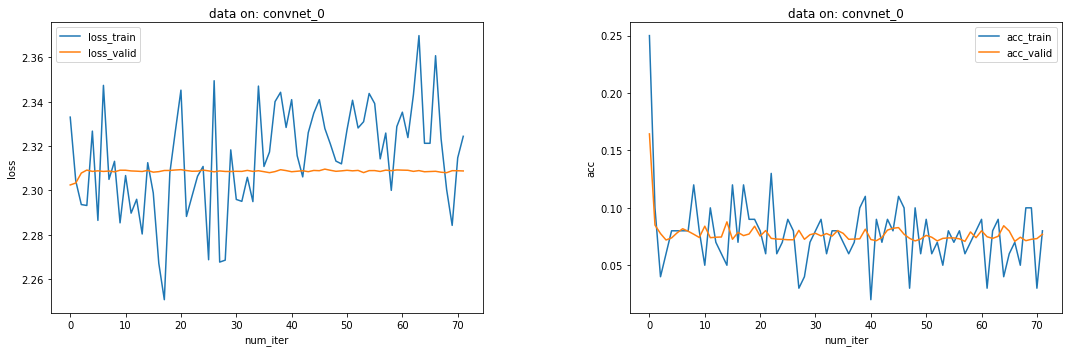

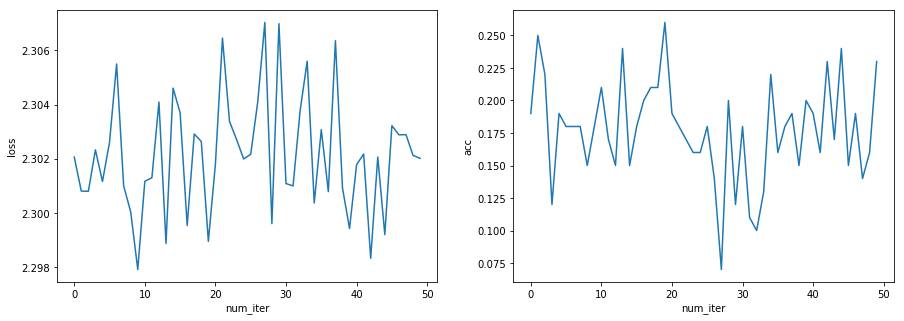

In [16]:
%%time

net_names = []

# init

net00 = ConvNet('net00').cuda() if use_cuda else ConvNet('net00')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam# (net00.parameters())

coach00 = CoachTeam_new(net00, optimizer, loss_func)

coach00.pipeline_helper(
    n_iters=2, 
    digit_rangesss=[range(4+1), range(4+1, 9+1)],
    sum_epochs=100
)

## 1.2 details

blabla...

# 2. ConvNet_1 [0~4 -> 0~9]

## 2.1 train and test

In [13]:
net_names = []

[Epoch: 49/50] [Batch: 550/600] [Loss-mean(train): 2.3216] [Loss-mean(validation): 2.3033] [Acc-mean(train): 0.1046] [Acc-mean(validation): 0.1111]
Save data(train & validation): OK in RAM, for range(0, 5)
[Epoch: 49/50] [Batch: 550/600] [Loss-mean(train): 2.3221] [Loss-mean(validation): 2.3034] [Acc-mean(train): 0.1054] [Acc-mean(validation): 0.1125]
Save data(train & validation): OK in RAM, for range(0, 10)
Train net: OK
Save data(test): OK in RAM
Save data in file OK: /home/ec2-user/git/convnet-report-aws/outputs_170908-175342/net01-sheet-train-1.csv
Save data in file OK: /home/ec2-user/git/convnet-report-aws/outputs_170908-175342/net01-sheet-valid-1.csv
Save data in file OK: /home/ec2-user/git/convnet-report-aws/outputs_170908-175342/net01-sheet-test-1.csv
Round 1: OK
---------------------------------
[Epoch: 49/50] [Batch: 550/600] [Loss-mean(train): 2.3241] [Loss-mean(validation): 2.3033] [Acc-mean(train): 0.1040] [Acc-mean(validation): 0.1111]
Save data(train & validation): OK i

/home/ec2-user/Locs/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


StopIteration: 

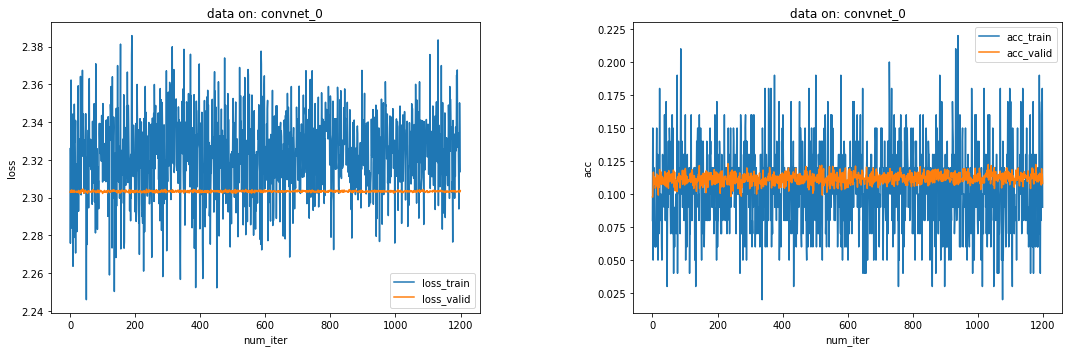

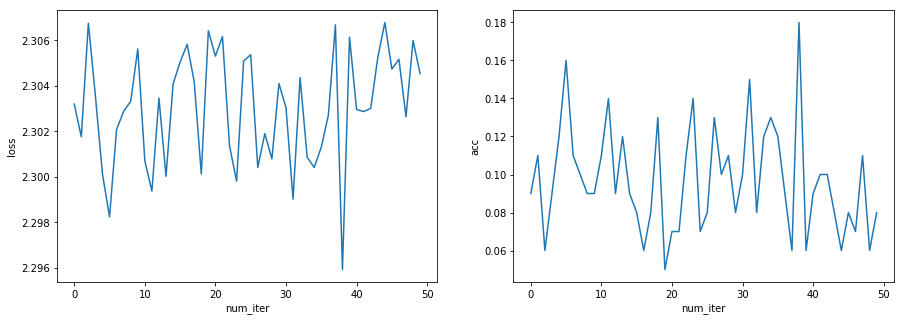

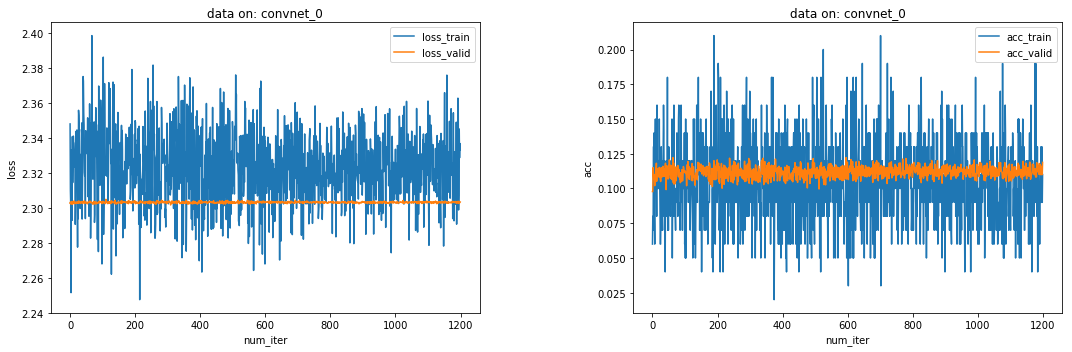

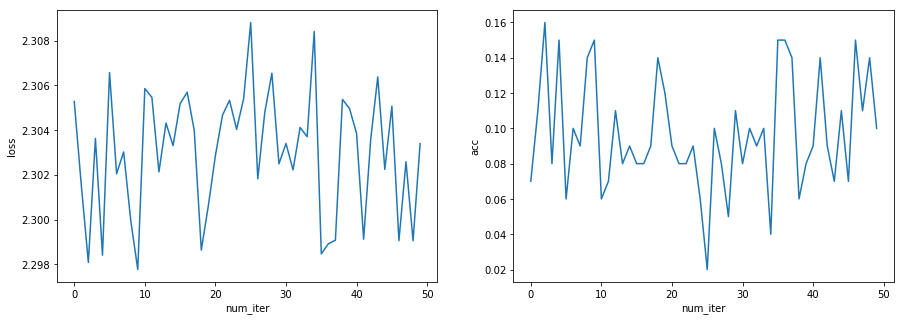

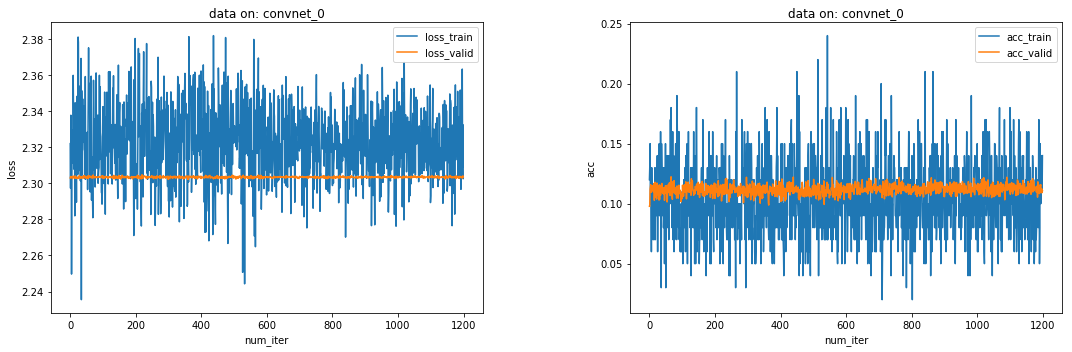

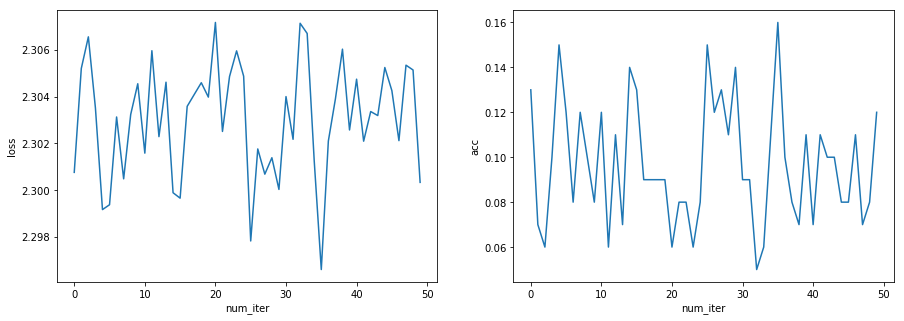

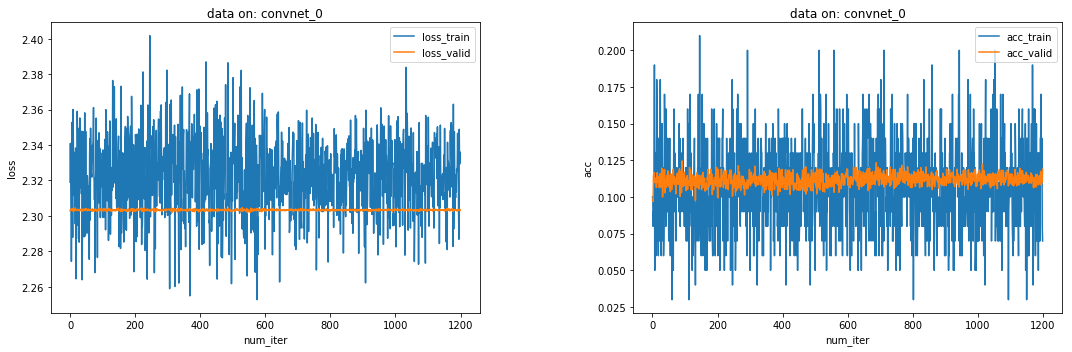

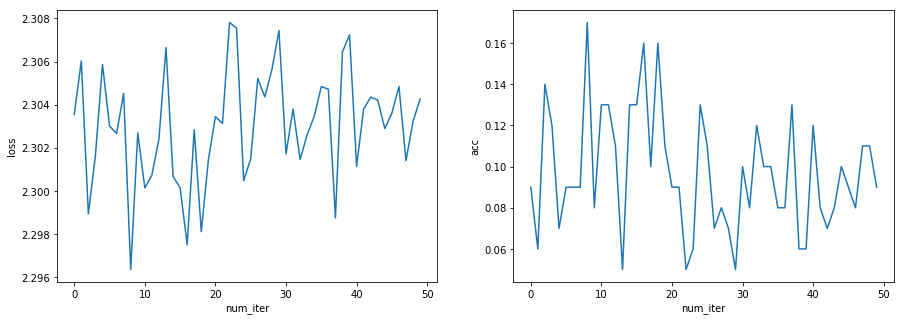

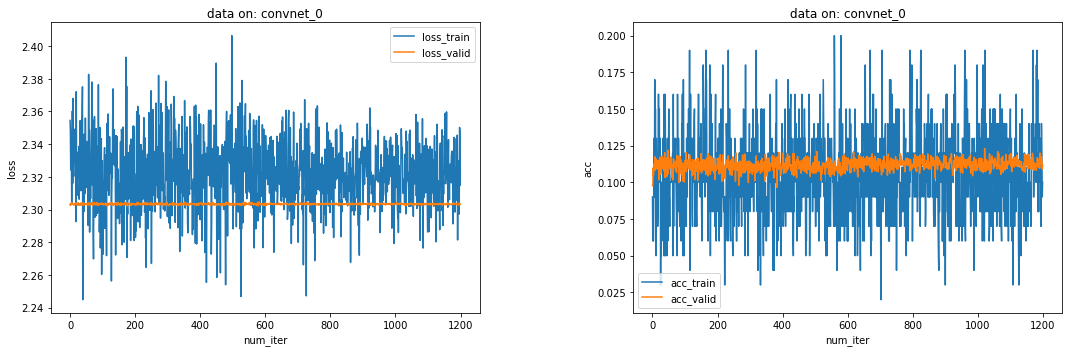

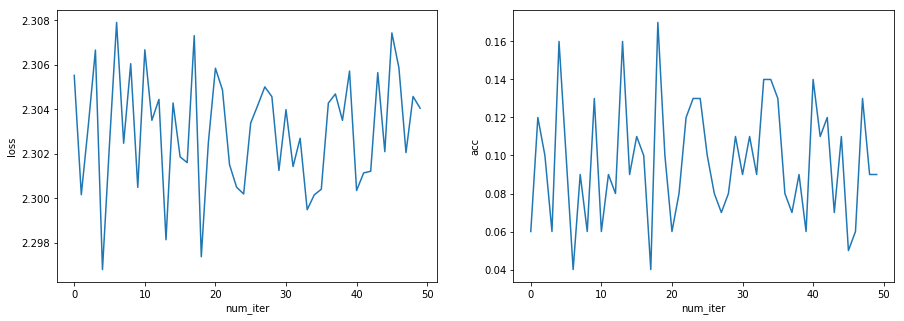

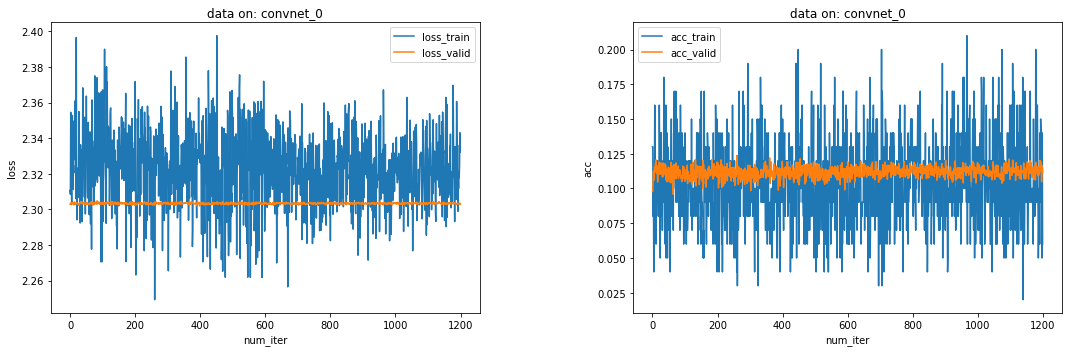

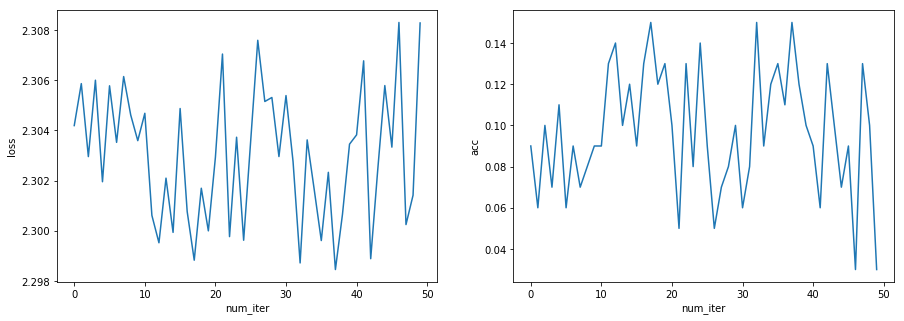

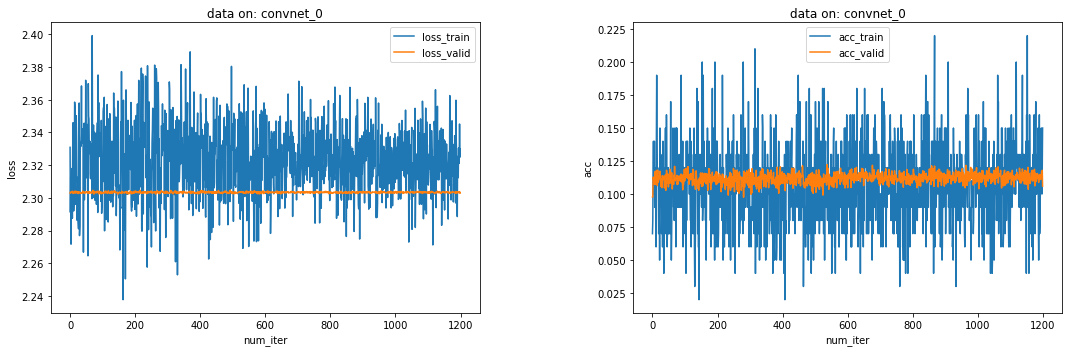

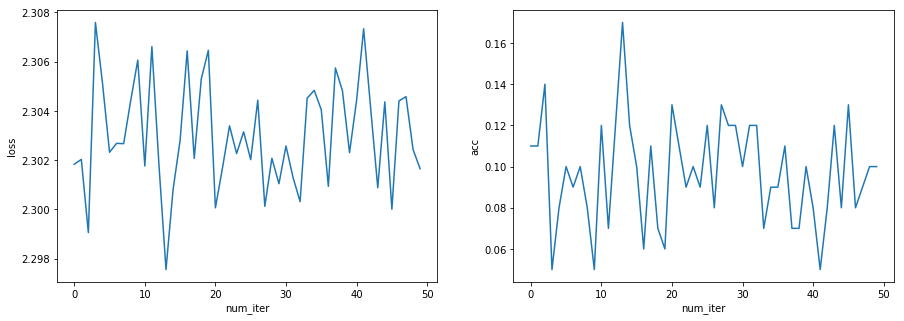

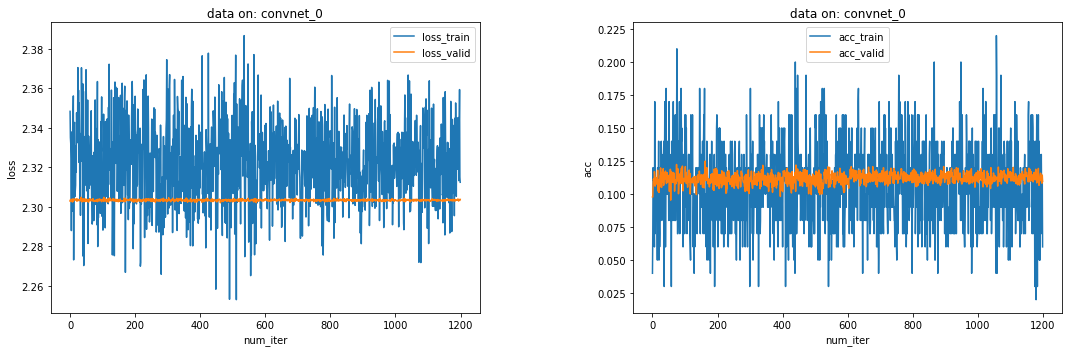

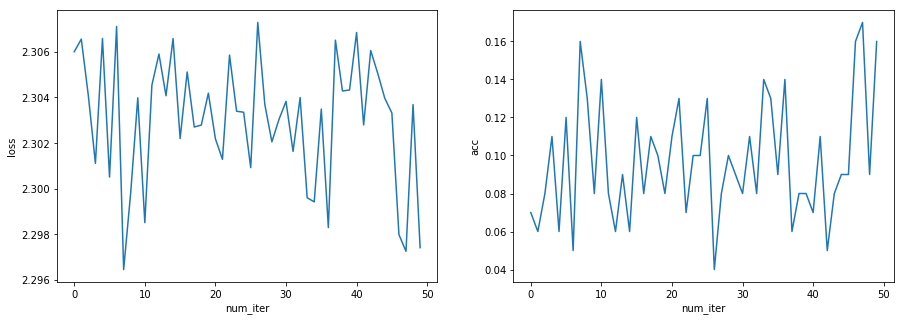

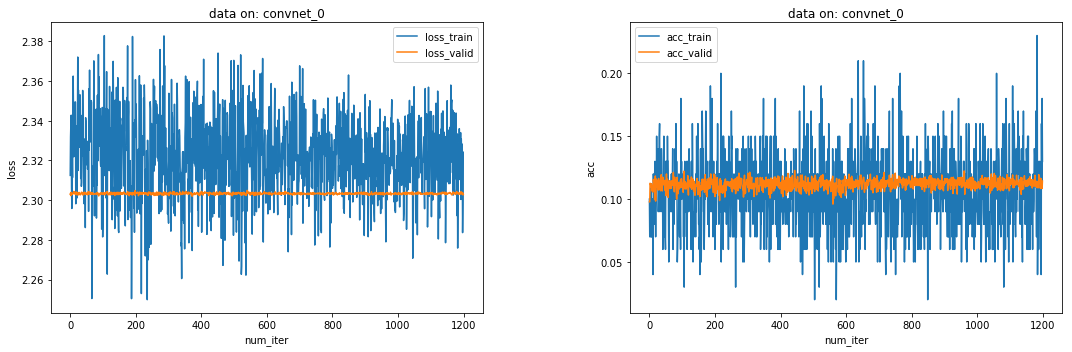

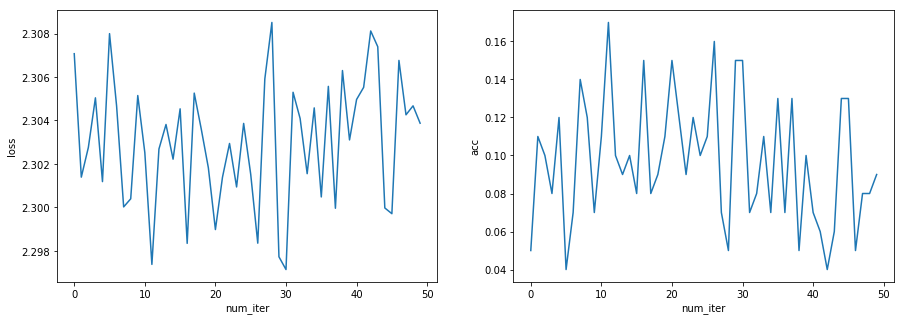

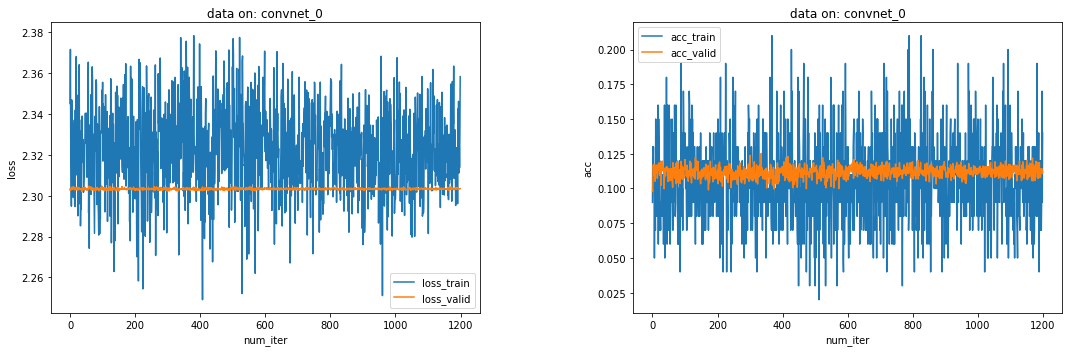

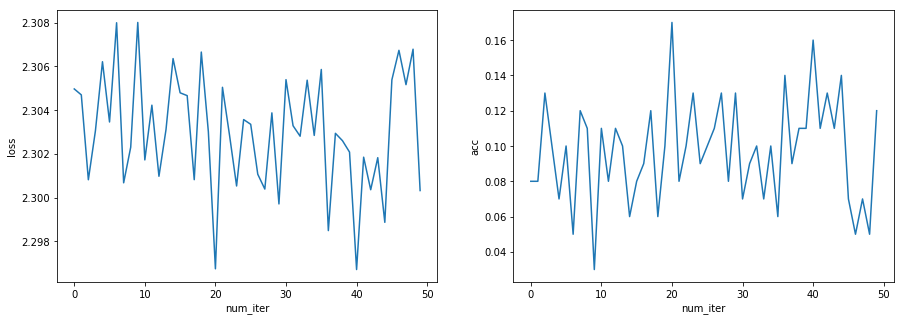

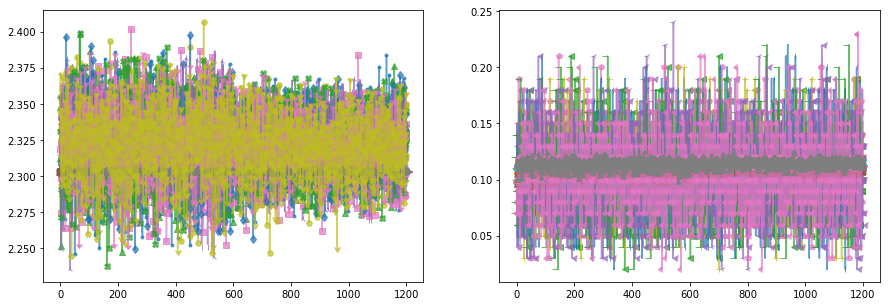

In [ ]:
%%time

# init

net01 = ConvNet('net01').cuda() if use_cuda else ConvNet('net01')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam# (net00.parameters())

coach01 = CoachTeam(net01, optimizer, loss_func)

coach01.pipeline_helper(
    n_iters=10, 
    digit_rangesss=[range(4+1), range(9+1)],
    sum_epochs=100
)

In [ ]:
print('hello')

## 2.2 details

blabla...

# 3. ConvNet_2 [0~9]

## 3.1 train and test

In [ ]:
%%time

# init

net02 = ConvNet('net02').cuda() if use_cuda else ConvNet('net02')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam# (net00.parameters())

coach02 = CoachTeam(net02, optimizer, loss_func)

coach02.pipeline_helper(
    n_iters=10, 
    digit_rangesss=[range(9+1)],
    sum_epochs=100
)

## 3.2 details

blabla...